# Vector representations of words

There are many methods one might use to build a semantic network with words as nodes and similarity scores as weights on edges. We could also threshold this weight and just keep unweighted edges that were greater than the threshold. A Bayesian approach like Latent Dirichlet Allocation would build a semantic network with weights being probabilities of relatedness. In this vector space model (VSM) of semantics, similarity is given by the cosine of the angle between two vector representations of words, $\mathbf{x}$ and $\mathbf{y}$,

\begin{equation}
\cos \theta = \frac{\mathbf{x} \cdot \mathbf{y}}{\lVert x \rVert \lVert y \rVert}
\end{equation}

In this notebook, I'll use TensorFlow to build and query a semantic network by following this tutorial: https://www.tensorflow.org/versions/r0.12/tutorials/word2vec/

In particular, I'm taking all the code from the file `word2vec_basic` that was being run as a script and putting it here, or I have rolled it in to other helper functions that I import. I tried to put the most relevant lines here so it was clear what the essential elements are. In the script `word2vec_basic.py`, I have put all these into a function called `run_word2vec()`.

In [6]:
from word2vec_basic import (
    maybe_download, read_data, build_dataset, generate_batch, run_word2vec
)

In [13]:
#filename = maybe_download('text8.zip', 31344016)

vocabulary = read_data('text8.zip')

In [14]:
vocabulary_size = 50000

data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size
)
print(type(data))
del vocabulary

data_index = 0

<class 'list'>


In [9]:
BATCH_SIZE = 20
batch, labels = generate_batch(data, count, dictionary, reverse_dictionary, batch_size=20, num_skips=2, skip_window=1)

In [10]:
# arrows indicate "in context of"
# Although BATCH_SIZE is 20, there are only 10 focal words (what is 
# correct tech term for these?), each with a window of one word on each
# side.
for i in range(BATCH_SIZE):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
          reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of
2 of -> 3134 abuse
2 of -> 195 term
3134 abuse -> 46 first
3134 abuse -> 2 of
46 first -> 59 used
46 first -> 3134 abuse
59 used -> 46 first
59 used -> 156 against
156 against -> 128 early
156 against -> 59 used
128 early -> 156 against
128 early -> 742 working


In [7]:
run_word2vec(data, count, dictionary, reverse_dictionary, vocabulary_size)

Initialized
Average loss at step  0 :  280.573486328
Nearest to known: generalship, bk, karim, apologists, pangloss, parks, jacobian, raining,
Nearest to often: strongly, coa, ironworks, permit, basketball, dieu, integer, expressway,
Nearest to six: amiga, ordo, adaptations, multiracial, believer, riffing, roxy, nawab,
Nearest to it: killed, aa, audi, pizzicato, seclusion, illustrate, reminds, reworked,
Nearest to american: cried, circuit, showings, paullus, flush, playoff, foresee, hindustani,
Nearest to such: pores, eyeglasses, yuan, unveils, boycott, imprisoned, heard, unfettered,
Nearest to is: epr, valleys, sofa, conjugal, bornu, chainmail, rough, verdict,
Nearest to an: eff, erm, simultaneity, bag, leopard, exchanged, deconstruction, dal,
Nearest to d: consequently, implemented, nightmarish, laziness, chipmunk, lucie, viewing, cnt,
Nearest to state: headers, ago, sfg, naxos, naci, oblivion, ataxia, gul,
Nearest to two: wt, cpu, electorate, tarkovsky, mina, continuity, mccartney, 

Average loss at step  52000 :  0.95212925604
Average loss at step  54000 :  0.950097527623
Average loss at step  56000 :  0.938702977329
Average loss at step  58000 :  0.94018282935
Average loss at step  60000 :  0.94024964264
Nearest to known: generalship, bk, karim, apologists, pangloss, parks, jacobian, raining,
Nearest to often: strongly, coa, ironworks, permit, basketball, dieu, integer, expressway,
Nearest to six: amiga, ordo, adaptations, multiracial, believer, riffing, roxy, nawab,
Nearest to it: taken, used, working, of, the, class, a, has,
Nearest to american: cried, circuit, showings, paullus, flush, playoff, foresee, hindustani,
Nearest to such: pores, eyeglasses, yuan, unveils, boycott, imprisoned, heard, unfettered,
Nearest to is: a, has, valleys, label, still, of, the, act,
Nearest to an: eff, erm, simultaneity, bag, leopard, exchanged, deconstruction, dal,
Nearest to d: consequently, implemented, nightmarish, laziness, chipmunk, lucie, viewing, cnt,
Nearest to state: he

OK, great, so we broke the script into slightly smaller pieces. But this is a little too much, still. I'd like to have this be like Bhat's lecture ipynbs, or the other tutorial nbs, where different elements of the graph are computed at different times. Before this, I want to build out the project infrastructure a bit more.

Here I'm going to try to extract the constituent parts for building and optimizing the network. Skipping the data (down)load part.

Somehow the embedding matrix is represented as a graph. This still does not make sense to me yet, so that's one of the goals I have at this point. 


### Part 1: Build a skip-gram model

The skip-gram model predicts the context of $2m$ words occurring in a window of width $m$. As explained in the comments of word2vec_basic.py, $m$ is called the `skip_window`. Another parameter does something I don't understand yet, but is related: `num_skips`.

I'm trying to read through three of the source papers, [Mikolov, et al., 2013. _Efficient Estimation of Word Representations in Vector Space_](http://arxiv.org/abs/1301.3781), [Mikolov, et al., 2013. _Distributed Representations of Words and Phrases and their Compositionality_](http://arxiv.org/abs/1310.4546), and [Gutman and Aapo, 2010. _Noise-contrastive estimation: A new estimation principle for unnormalized statistical models_](http://www.cs.helsinki.fi/u/ahyvarin/papers/Gutmann10AISTATS.pdf). I'll add notes from these as I'm able.

In the code, the first step in `run_word2vec`, which I composed from parts of the script `word2vec_basic.py`, is to create the `valid_examples` array. 

In [13]:
# create some helper functions to identify different blocks
# and simplify the code that sets up the computations

import tensorflow as tf
import math

# function for creating training inputs and labels
def make_training_placeholders(batch_size):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    
    return train_inputs, train_labels


# create loss function; requires embeddings be created first and passed
def make_loss_op(embeddings, vocabulary_size, 
                 embedding_size, train_inputs):
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size))
    )
    
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    return tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size
        )
    )

In [14]:
# now construct loss and optimizer, which will be run in same
# session.run call in another cell

# need to define some important variables
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
# equivalent to the K parameter in NCE paper
num_sampled = 64

# let's reload the data as a reminder; don't run this multiple 
# times like a dope
filename = maybe_download('text8.zip', 31344016)
vocabulary = read_data(filename)
vocabulary_size = 50000
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size
)

Found and verified text8.zip


In [40]:
graph = tf.Graph()

with graph.as_default():
    
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
    )

    train_inputs, train_labels = make_training_placeholders(batch_size)

    loss = make_loss_op(embeddings, vocabulary_size, 
                        embedding_size, train_inputs)

    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)


    # just used to display model accuracy; doesn't affect calculation
    valid_size = 4
    valid_window = 100
    valid_examples = np.random.choice(valid_window, valid_size, replace=False)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # cosine similarity between minimatch examples and embeddings
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset
    )
    # why should this be similarity? write it out below
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True
    )

    # add variable initializer for the variables we've just defined 
    init = tf.global_variables_initializer()

### Part 2: Train a skip-gram model

In [44]:
# define some helper functions to print interesting metrics
def more_frequent_printout(step, average_loss):
    if step > 0:
        average_loss /= 2000
    print('Average loss at step {}:'.format(step), average_loss)
    average_loss = 0
    
    
def less_frequent_printout(similarity, valid_size, reverse_dictionary,
                           valid_examples, num_nearest=8):
    # Run calculation of similarity at this timestep.
    # expensive b/c similarity involves mat-mat mult of 
    # embedding matrix 
    sim = similarity.eval()
    # now iterate through all `valid_size` words and see 
    # nearest `num_nearest` neighbors
    for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = num_nearest
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        
        log_str = 'Nearest to {}:'.format(valid_word)
        
        for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = '{} {},'.format(log_str, close_word)
        
        print(log_str[:-1])

In [45]:
# code that sets up a session and trains the network within that session

num_steps = 10001

with tf.Session(graph=graph) as session:
    
    init.run()
    
    average_loss = 0
    for step in range(num_steps):
        # select random batches of contexts to train on
        batch_inputs, batch_labels = generate_batch(
            data, count, dictionary, reverse_dictionary,
            batch_size, num_skips, skip_window
        )
        # each batch has a different feed_dict
        feed_dict = {train_inputs: batch_inputs, 
                     train_labels: batch_labels}
        
        # run the session for the current batch
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 1000 == 0:
            more_frequent_printout(step, average_loss)
        
        if step % 3000 == 0 and step > 0:
            less_frequent_printout(similarity, valid_size,
                                   reverse_dictionary, valid_examples,
                                   num_nearest=10)

    final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 273.19909668
Average loss at step 1000: 62.524368
Average loss at step 2000: 96.6401708021
Average loss at step 3000: 119.657098875
Nearest to i: relocated, ean, wearer, fingered, hmos, pcm, roy, hobbyist, competent, sident
Nearest to only: sca, implantation, threat, bandit, starr, rationing, uml, kasparov, end, camels
Nearest to time: destroyer, mascarenes, pressure, vig, veneer, turns, ribs, tiberian, subscribers, methionine
Nearest to with: cuauht, cro, skaro, shams, nmt, snare, testify, probe, prevail, voter
Average loss at step 4000: 136.884147372
Average loss at step 5000: 150.085542099
Average loss at step 6000: 160.310264404
Nearest to i: relocated, ean, wearer, fingered, hmos, pcm, roy, hobbyist, competent, sident
Nearest to only: sca, implantation, threat, bandit, starr, rationing, uml, kasparov, end, camels
Nearest to time: destroyer, mascarenes, pressure, vig, veneer, turns, ribs, tiberian, subscribers, methionine
Nearest to with: cuauht, cro, skaro,

In [43]:
# output embeddings have dimension V x D, where V is the size of
# the vocabulary and D is the embedding dimension 
# (50000 x 128 in our example)
final_embeddings.shape

(50000, 128)

## [Word embedding directory in the tensorflow/models GitHub repo](https://github.com/tensorflow/models/tree/master/tutorials/embedding)

## Run word2vec code with Sep - Nov 2016

The `text8` file is about 17 million words; each of the network files is 10 - 12 million words.

In [93]:
from word2vec_basic import (
    maybe_download, read_data, build_dataset, generate_batch, run_word2vec
)

def demo_word2vec(filename, vocabulary_size=50000, 
                  batch_size=128, num_skips=2, skip_window=4,
                  embedding_size=128, num_sampled=128,
                  num_steps=10001, learning_rate=1.0):
    '''
    Simple wrapper around run_word2vec with many frozen default values:
    embedding_size, valid_size, and valid_window are all frozen out 
    in the call to run_word2vec below
    '''
    print('reading data')
    vocabulary = read_data(filename)
    full_vocabulary_size = len(np.unique(vocabulary))
    
    vocabulary_size = min((vocabulary_size, full_vocabulary_size))
    print('building dataset')
    data, count, dictionary, reverse_dictionary = build_dataset(
        vocabulary, vocabulary_size
    )
    del vocabulary
    
    print('generating batches')
    batch, labels = generate_batch(data, count, dictionary, 
                                   reverse_dictionary)

    print('running word2vec')
    final_embeddings = run_word2vec(data, count, dictionary, 
                                    reverse_dictionary, vocabulary_size, 
                                    batch_size=batch_size, 
                                    num_skips=num_skips, 
                                    skip_window=skip_window,
                                    num_sampled=num_sampled,
                                    embedding_size=embedding_size,
                                    num_steps=num_steps,
                                    learning_rate=learning_rate)
    
    return final_embeddings, dictionary, reverse_dictionary

In [95]:
emb, d, revd = demo_word2vec('MSNBCW-2016.txt', 
                             num_steps=10000, learning_rate=1.0,
                             num_sampled=100, embedding_size=128)

reading data
building dataset
generating batches
running word2vec
Initialized
Average loss at step  0 :  364.887298584
Average loss at step  2000 :  48.6239978988
Average loss at step  4000 :  4.81445081186
Nearest to trump: next, hillary, clinton, tightening, new, gained, chris, utah,
Nearest to clinton: donald, trump, polls, tightening, good, unloading, matthews, play,
Nearest to conservative: struggling, heated, yucking, unresolved, incredible, newscaster, accelerate, searches,
Nearest to liberal: castle, cut, wreckage, consider, tolerant, plainly, yielding, constant,
Average loss at step  6000 :  2.15700284362
Average loss at step  8000 :  1.78029609388
Nearest to trump: clinton, hillary, tightening, polls, chris, next, post, gained,
Nearest to clinton: trump, polls, donald, tightening, hillary, points, matthews, washington,
Nearest to conservative: struggling, heated, yucking, unresolved, incredible, newscaster, accelerate, searches,
Nearest to liberal: castle, cut, wreckage, cons

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


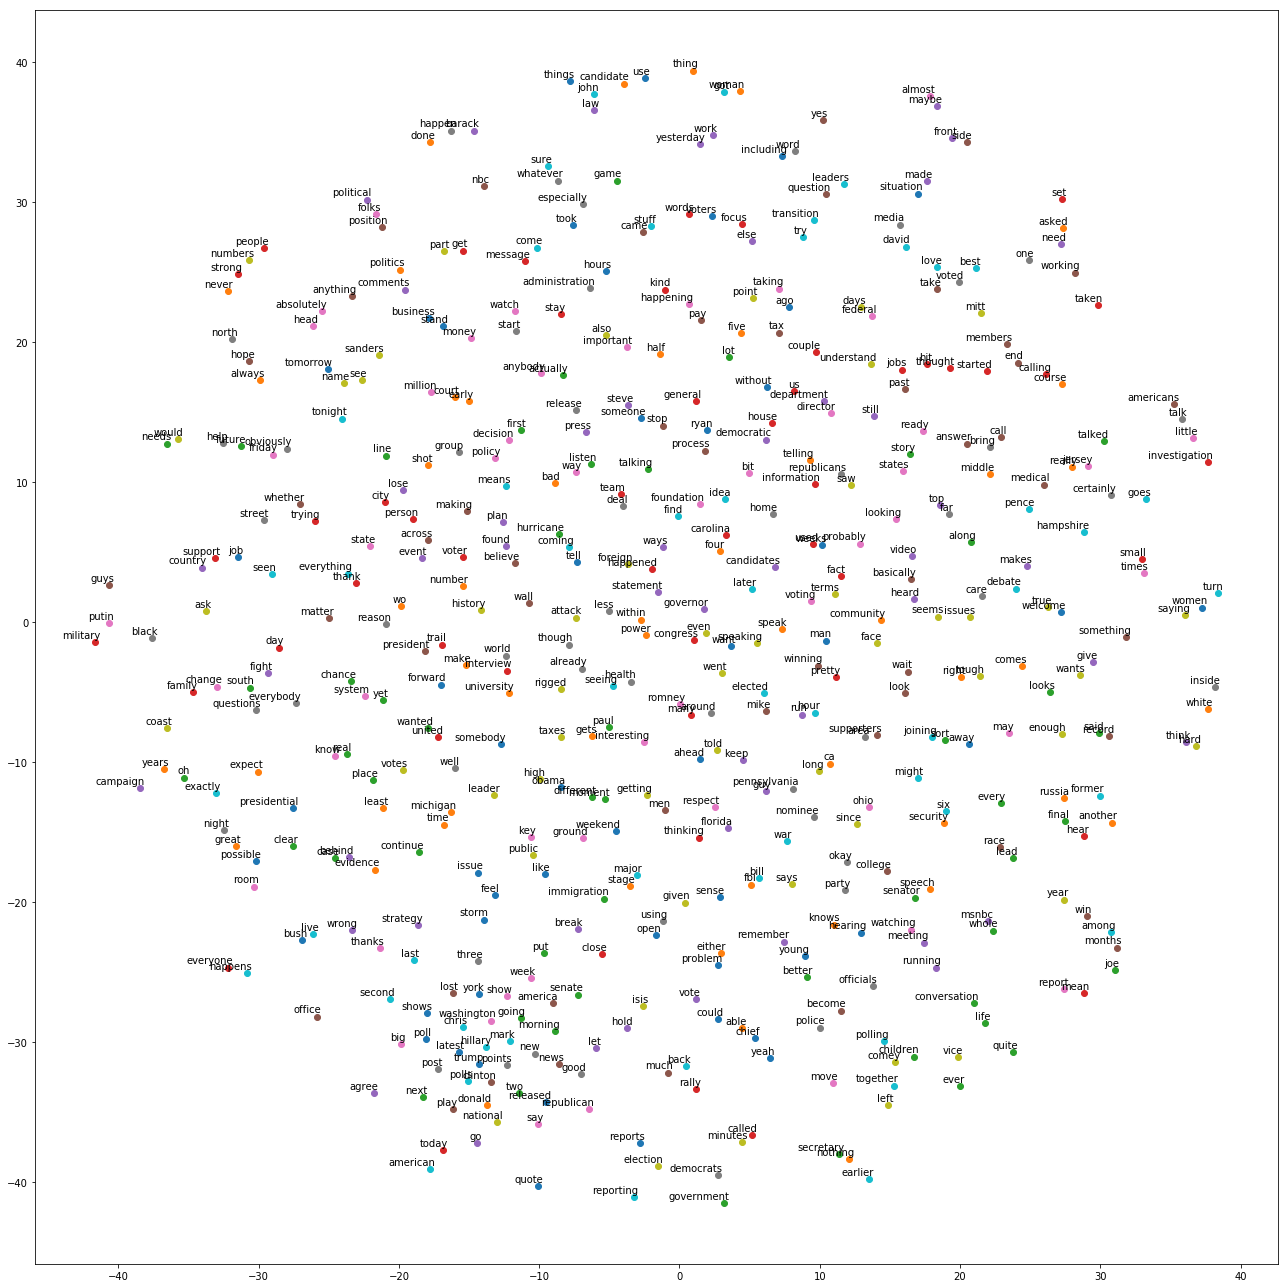

In [100]:
from word2vec_basic import plot_with_labels

num_to_plot = 500
labels = [revd[i] for i in range(num_to_plot)]
plot_with_labels(emb, num_to_plot, labels, 'test.pdf')

## Reflections

There are two transformations that were useful before that I have not done here yet. The first is to get rid of stop words. We actually remove low-frequency words by removing all words below the 50,000 most frequent. But does this do a good job? There was a different thing done when I was working on the Cog Sci submission, which I think was to get rid of all words that only occurred once in the corpus. 

In the more advanced word2vec tutorials they use a smoothing for the noise-contrastive estimation distribution, where more frequent words are less likely to be chosen for contrast (correct?). This is similar to the scaling of the frequencies before SVD was calculated in PPMI.

Next I'll implement some of these transformations and see if we get more sensible neighbors. Perhaps too the learning rate is not correct? Maybe we need a different dimensionality for the embedding? To understand all these better, some basic facts would be helpful, including "how many words in the vocabulary (that occur more than once)?" 